# Imports

In [11]:
from math import cos, sin, pi, sqrt
import math 
import numpy as np  # 1.25.1
from collections import defaultdict
import os
from sklearn.cluster import KMeans  # 0.24.2
from sklearn.linear_model import LinearRegression
import pickle 
from scipy.spatial import distance, cKDTree, Delaunay  # 1.11.1
from tqdm import tqdm  # 4.62.3
import random 
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl  # 3.4.3

# Toy Problems

In [14]:
def unwrap(x, bounds):
    # [0, 1] -> [low, high]
    return x * (bounds["high"]-bounds["low"]) + bounds["low"]

def wrap(x, bounds):
    # [low, high] -> [0, 1] 
    return (x - bounds["low"]) / (bounds["high"]-bounds["low"]) 

## 10-DoF Arm

In [15]:
class Arm:
    def __init__(self, lengths):
        self.n_dofs = len(lengths)
        self.lengths = np.concatenate(([0], lengths))
        self.joint_xy = []

    def fw_kinematics(self, p):
        assert(len(p) == self.n_dofs)
        p = np.append(p, 0)
        self.joint_xy = []
        mat = np.matrix(np.identity(4))
        for i in range(0, self.n_dofs + 1):
            m = [[cos(p[i]), -sin(p[i]), 0, self.lengths[i]],
                 [sin(p[i]),  cos(p[i]), 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            mat = mat * np.matrix(m)
            v = mat * np.matrix([0, 0, 0, 1]).transpose()
            self.joint_xy += [v[0:2].A.flatten()]
        return self.joint_xy[self.n_dofs], self.joint_xy

def arm(angles, task):
    angular_range = task[0] / len(angles)
    lengths = np.ones(len(angles)) * task[1] / len(angles)
    target = 0.5 * np.ones(2)
    a = Arm(lengths)
    # command in
    command = (angles - 0.5) * angular_range * math.pi * 2
    ef, _ = a.fw_kinematics(command)
    f = np.exp(-np.linalg.norm(ef - target))
    return f

In [16]:
def eval_command_arm_ME(c, s, elite_id, command_bounds, situation_bounds, kind, verbose=0):
    r = arm(c, s)
    evaluation = {"reward": r}
    evaluation["command"] = c
    evaluation["situation"] = s
    evaluation["id"] = elite_id
    evaluation["kind"] = kind
    return evaluation

## Archery

In [17]:
def compute_archery_situation(n, archery_state_bounds):
    res = {}
    bounds = {"low": [], "high": []}
    for i in range(n):
        for key, bound in archery_state_bounds.items():
            bounds["low"].append(bound["low"])
            bounds["high"].append(bound["high"])
    res["bounds"] = {"low": np.array(bounds["low"]), "high": np.array(bounds["high"])}
    res["dim"] = len(bounds["high"])
    return res

def compute_archery_command(n, archery_action_config, iso_sigma, line_sigma):
    action_bounds = {"low": np.concatenate([archery_action_config["low"] for _ in range(n)]), "high":  np.concatenate([archery_action_config["high"] for _ in range(n)])}
    return {"bounds": action_bounds, "iso_sigma": iso_sigma, "line_sigma": line_sigma, "dim": len(action_bounds["low"])}

In [18]:
def eval_archery(c, s, verbose=0):
    n = len(s)//2
    assert(n==1)
    rewards = {}
    for i in range(n):
        [yaw, pitch] = c[2*i:2*i+2]
        if type(s) == dict:
            d = s[f"d_{i}"] # distance
            w = s[f"w_{i}"] # wind
        else:
            d = s[2*i] # distance
            w = s[2*i+1] # wind
        v0 = 70
        # average velocity of an arrow 70 m.s-1 
        # with yaw = 0, pitch = 0.5 * arcsin(g*d/v0**2)
        v = v0 * np.array([-np.sin(yaw), np.cos(yaw)*np.cos(pitch), np.cos(yaw) * np.sin(pitch)])
        if v[1] <= 0:
            rewards[i] = 0
        else:
            t = d/v[1]
            contact = np.array([0.5*w*t**2+v[0]*t, -0.5*9.8*t**2+v[2]*t])
            distance = np.linalg.norm(contact)
            # 6.1cm rayon par tranche, 10 tranches, 122cm au total
            rewards[i] = max(0, int(10-distance//0.061))/10
    reward = rewards[0]
    return {"reward": reward, "rewards": rewards}

In [19]:
def eval_command_archery_ME(c, s, elite_id, command_bounds, situation_bounds, kind, verbose=0):
    evaluation = eval_archery(unwrap(c, command_bounds), unwrap(s, situation_bounds), verbose=verbose)
    evaluation["command"] = c
    evaluation["situation"] = s
    evaluation["id"] = elite_id
    evaluation["kind"] = kind
    return evaluation

In [20]:
archery_state_bounds = {"d": {"low": 5, "high": 40}, "w": {"low": -10, "high": 10}}
archery_action_bounds = {"low": np.array([-np.pi/12, -np.pi/12]), "high": np.array([np.pi/12, np.pi/12])}

# Parametric-Task MAP-Elites 

## Variation Operators

In [21]:
def iso_line_dd(x, y, command_config):
    line_sigma, iso_sigma, dim = command_config['line_sigma'], command_config['iso_sigma'], command_config["dim"]
    candidate = x + np.random.normal(0, iso_sigma) + np.random.normal(0, line_sigma) * (y-x) 
    return np.clip(candidate, np.zeros(dim), np.ones(dim))

In [22]:
def sbx(x, y, command_config):
    '''
    SBX (cf Deb 2001, p 113) Simulated Binary Crossover

    A large value ef eta gives a higher probablitity for
    creating a `near-parent' solutions and a small value allows
    distant solutions to be selected as offspring.
    '''
    eta = 10 # command_config["eta"] 
    xl = 0
    xu = 1
    z = x.copy()
    r1 = np.random.random(size=len(x))
    r2 = np.random.random(size=len(x))
    
    for i in range(0, len(x)):
        if abs(x[i] - y[i]) > 1e-15:
            
            x1 = min(x[i], y[i])
            x2 = max(x[i], y[i])
                        
            beta = 1.0 + (2.0 * (x1 - xl) / (x2 - x1))
            alpha = 2.0 - beta ** -(eta + 1)
            rand = r1[i]
            
            if rand <= 1.0 / alpha:
                beta_q = (rand * alpha) ** (1.0 / (eta + 1))
            else:
                beta_q = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1))

            c1 = 0.5 * (x1 + x2 - beta_q * (x2 - x1))

            beta = 1.0 + (2.0 * (xu - x2) / (x2 - x1))
            alpha = 2.0 - beta ** -(eta + 1)
                
            if rand <= 1.0 / alpha:
                beta_q = (rand * alpha) ** (1.0 / (eta + 1))
            else:
                beta_q = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1))
            c2 = 0.5 * (x1 + x2 + beta_q * (x2 - x1))

            c1 = min(max(c1, xl), xu)
            c2 = min(max(c2, xl), xu)

            if r2[i] <= 0.5:
                z[i] = c2
            else:
                z[i] = c1

    return z

In [23]:
variation_operators = {
    "iso-line-dd": iso_line_dd,
    "sbx": sbx,
}

In [24]:
def regression(s, archive, config):
    """ local linear regression  """
    _, idx = archive.tree.query(s, k=1)
    indexes = archive.centroid_neighbors[idx]  # find the direct neighbors using the precomputed delauney from the centroids 
    X = [archive.elites[i]["situation"] for i in indexes]
    Y = [archive.elites[i]["command"] for i in indexes]
    reg = LinearRegression().fit(X, Y)
    c = reg.predict(np.array([s]))[0] 
    dim = len(c)
    return np.clip(c + np.random.normal(0, config["linreg_sigma"]) * np.std(Y, axis=0), np.zeros(dim), np.ones(dim))

## Tournament

In [25]:
def closest2parent_tournament(s, archive, config):
    k = archive.k_closest2parent
    tasks = np.random.random((k, config["situation_config"]["dim"]))
    _, indexes = archive.tree.query(tasks, k=1)
    situations = [archive.elites[i]["situation"] for i in indexes]
    distances = distance.cdist(situations, [s], "euclidean") 
    selected_task = tasks[np.argmin(distances)]
    return selected_task

## Bandit

In [26]:
class Bandit():
    
    def __init__(self, values):
        self.successes = defaultdict(int)
        self.selected = defaultdict(int)
        self.log = []
        self.values = values
        
    def update(self, key, success):
        self.successes[key] += success
        self.selected[key] += 1 
        n = 0
        for n_value in self.selected.values():
            n += n_value

        if len(self.successes.keys()) < len(self.values):
            k = random.choice(self.values)
        else:
            ucb = []
            for k in self.values:
                n_a = self.selected[k]
                mean = self.successes[k] / n_a
                ucb += [mean +  math.sqrt(2 * math.log(n) / n_a)]
            k = self.values[np.argmax(ucb)]
            
        self.log.append(k)
        return k

## Archive

In [27]:
def cvt(k, dim, coef=10, verbose=False):
    x = np.random.rand(k*coef, dim)
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=1, verbose=False)#,algorithm="full")
    k_means.fit(x)
    X = k_means.cluster_centers_
    return X

In [28]:
class Archive():
    
    def __init__(self, config):
        self.situation_config = config["situation_config"]
        self.command_config = config["command_config"]
        self.eval_command = config["eval_command"]
        
        self.k_closest2parent = 1
        self.bandit_values = [1, 5, 10, 50, 100, 500]
        self.bandit_closest2parent = Bandit(self.bandit_values)
        
        self.samples = []
        self.it = 0
        self.n_cells = config["n_cells"]
        self.create_centroids()
        self.tree = cKDTree(self.centroids, leafsize=2)  
        self.elites = [None for _ in range(self.n_cells)] 

        for i in range(self.n_cells):
            evaluation = self.eval_command(np.random.rand(self.command_config["dim"]), self.centroids[i], i, self.command_config["bounds"], self.situation_config["bounds"], "random")
            evaluation["it"] = self.it
            self.samples.append(evaluation)
            self.it += 1 
            self.elites[i] = evaluation

    def create_centroids(self):
        if self.n_cells <= 10_000:
            self.centroids = cvt(self.n_cells, self.situation_config["dim"])
        else:
            self.centroids = np.random.random((self.n_cells, self.situation_config["dim"]))
        delauney = Delaunay(self.centroids)
        neighbors = [[i] for i in range(self.n_cells)]
        for neighborhood in delauney.simplices:
            for i in neighborhood:
                for j in neighborhood:
                    neighbors[i].append(j)
                    neighbors[j].append(i)
        self.centroid_neighbors = [list(set(n)) for n in neighbors]
    
    def add_evaluation(self, evaluation):
        _, index = self.tree.query(evaluation["situation"], k=1)
        evaluation["it"] = self.it 
        self.samples.append(evaluation)
        self.it += 1         
        is_elite = evaluation["reward"] >= self.elites[index]["reward"]
        if is_elite:
            self.elites[index] = evaluation
    
        if "closest2parent" in evaluation["kind"]:
            self.k_closest2parent = self.bandit_closest2parent.update(self.k_closest2parent, is_elite)
        return is_elite

## Main Loop

In [29]:
def PTME(config):
    archive = Archive(config)
    for current_it in tqdm(range(archive.it, config['budget']), ncols=150, smoothing=0.01, mininterval=1.):
        if np.random.random() < config["proba_regression"]:
            s = np.random.random(config["situation_config"]["dim"])
            c = regression(s, archive, config)
            selected_operator = "regression"
        else:
            x, y = archive.elites[np.random.randint(archive.n_cells)], archive.elites[np.random.randint(archive.n_cells)]
            c = variation_operators[config["variation_operator"]](x["command"], y["command"], config["command_config"])
            s = closest2parent_tournament(x["situation"], archive, config)
            selected_operator = "sbx_closest2parent"
        sample = (c, s, current_it, config["command_config"]["bounds"], config["situation_config"]["bounds"], selected_operator, config['verbose'])
        evaluation = config["eval_command"](*sample)      
        archive.add_evaluation(evaluation)
    return {"archive": archive, "config": config}

# Config

In [30]:
config = {
    # MAP-Elite
    "budget": 100_000,
    "verbose": 1,
    "n_cells": 200,
    "linreg_sigma": 1.,
    "proba_regression": 0.5,
    "variation_operator": "sbx", # "sbx" or "iso-line-dd"
}

In [31]:
env = "arm"
if env == "archery":
    config["eval_command"] = eval_command_archery_ME
    config["command_config"] = compute_archery_command(1, archery_action_bounds, line_sigma=0.2, iso_sigma=0.01)
    config["situation_config"] = compute_archery_situation(1, archery_state_bounds)
elif env == "arm":
    config["eval_command"] = eval_command_arm_ME
    config["command_config"] =  {"dim": 10, "bounds": None, "line_sigma": 0.2, "iso_sigma": 0.01}
    config["situation_config"] = {"dim": 2, "bounds": None}
env_names = {'arm': '10-D Arm', "archery": "Archery", "talos": "Talos Door Opening"}
env_name = env_names[env]

# Execute

In [33]:
N = 1
Res = {}
for i in range(N):
    Res[i] = PTME(config)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 99800/99800 [01:06<00:00, 1499.98it/s]


# PLOT

## Solutions on the task space

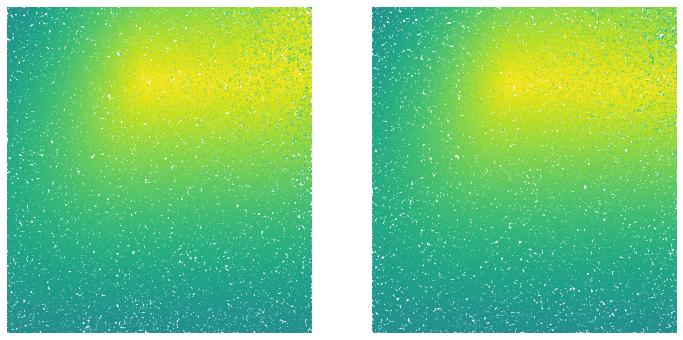

In [ ]:
fig, ax = plt.subplots(figsize=(6*len(Res), 6))
for j, res in enumerate(Res.values()): 
    ax = plt.subplot2grid((1, len(Res)), (0, j))
    situation = np.array([ev["situation"] for ev in res["archive"].samples])
    rewards = np.array([ev["reward"] for ev in res["archive"].samples])
    indices = np.argsort(rewards)
    plt.scatter(situation[indices,0], situation[indices,1], s=1, c=rewards[indices], vmin=0, vmax=1)
    plt.axis("off")
    plt.xlim((0,1.)) 
    plt.ylim((0,1.))  

## QD-Score and MR-QD-Score

In [35]:
linestyles = [
       (0, (1, 1)), #    ('dotted',  
       (0, (5, 5)),  #      ('dashed',             
       (0, (3, 5, 1, 5)),  #      ('dashdotted',           
       (0, (3, 5, 1, 5, 1, 5)),  #     ('dashdotdotted',      
       (5, (10, 3)),  #      ('long dash with offset', 
    
       (0, (5, 1)),  #     ('densely dashed',     
       (0, (3, 1, 1, 1)),  #      ('densely dashdotted',  
       (0, (3, 1, 1, 1, 1, 1)),  #      ('densely dashdotdotted', 

       (0, (1, 10)), #      ('loosely dotted',        
       (0, (5, 10)),  #      ('loosely dashed',       
       (0, (3, 10, 1, 10)),  #      ('loosely dashdotted',    
       (0, (3, 10, 1, 10, 1, 10)),  #      ('loosely dashdotdotted',
] 

In [37]:
def general_master(jobs, n_processes=1, verbose=1, batch_size=None):
    if batch_size is None:
        return general_master_batch(jobs, n_processes, verbose)
    else:
        batches = []
        for i in range(int(np.ceil(len(jobs)/batch_size))):
            batches.append(general_master_batch(jobs[i*batch_size:(i+1)*batch_size], n_processes, verbose))

        Res = {}
        for batch in batches:
            for key, val in batch.items():
                Res[key] = val
        
        return Res 

In [38]:
def make_general_jobs(foo, args):
    jobs = []
    for name, arg in args.items():
        jobs.append((foo, name, arg))
    return jobs

def general_worker(job_queue, res_queue):
    while True:
        job = job_queue.get()
        if job == "Done":
            break
        else:
            f, name, arg = job
            if type(arg) == tuple:
                res_queue.put((name, f(*arg)))
            elif type(arg) == dict:
                res_queue.put((name, f(**arg)))
            else:
                res_queue.put(None)

def general_master_batch(jobs, n_processes=1, verbose=1):
    if len(jobs) == 1:
        for job in jobs:
            f, name, arg = job
            if type(arg) == tuple:
                return {name: f(*arg)}
            elif type(arg) == dict:
                return {name: f(**arg)}
            
    job_queue = mp.Queue()
    res_queue = mp.Queue()
    n_processes = min(n_processes, len(jobs))
    pool = mp.Pool(n_processes, general_worker, (job_queue, res_queue))

    for job in jobs:
        job_queue.put(job)

    for _ in range(n_processes):
        job_queue.put("Done")
    
    res = {}
    for i in (tqdm(range(len(jobs)), smoothing=0.) if verbose else range(len(jobs))):
        name, out = res_queue.get()
        res[name] = out
        
    pool.terminate()
    return res 

In [39]:
def open_pickle(path):
    if os.path.exists(path):
        with open(path, "rb") as f:
            res = pickle.load(f)
        return res 

In [48]:
arm_min = open_pickle("./data/arm_minimum.pk")
arm_max = open_pickle("./data/arm_maximum.pk")

def compute_cell_min_max(step_size):
    cells_min = defaultdict(list)
    cells_max = defaultdict(list)
    for key in arm_min.keys():
        ckey = tuple([int(x) for x in np.array(arm_min[key]["s"])/step_size])
        cells_min[ckey].append(arm_min[key]["r"])
        cells_max[ckey].append(arm_max[key]["r"])
    for key in cells_min.keys():
        cells_min[key] = np.min(cells_min[key])
        cells_max[key] = np.max(cells_max[key])
    return cells_min, cells_max

In [41]:
def compute_qd_score(res, resolutions):
    qd_score = {}
    for step_size in resolutions:
        cells = defaultdict(list)
        if env in ["talos", "arm"]:
            cells_min, cells_max = cells_min_max[step_size]
        for i in range(len(res["archive"].samples)):
            key = tuple([int(x) for x in res["archive"].samples[i]["situation"]/step_size])
            cells[key].append(res["archive"].samples[i]["reward"])
        for key in cells.keys():
            if env == "arm":
                cells[key] = (np.max(cells[key])-cells_min[key])/(cells_max[key]-cells_min[key])
            elif env == "talos":
                cells[key] = (np.max(cells[key])-cells_min)/(cells_max-cells_min)
            else:
                cells[key] = np.max(cells[key])
        qd_score[step_size] = sum((x for x in cells.values())) * step_size**len(key)
    return qd_score

In [42]:
def plot_with_spread(data, names, X, colors=cm.rainbow, lw=3, alpha=0.3, line_styles=None, plot_fst_variance=True, plot_snd_variance=False):
    """
    dim0: different methods
    dim1: abscice 
    dim2: replication 
    """
    line_styles = ["-"] * len(data) if line_styles is None else line_styles
    for i, Y in enumerate(data):
        median = [np.median(y) for y in Y]
        q_05 =  [np.quantile(y, 0.05) for y in Y] 
        q_25 =  [np.quantile(y, 0.25) for y in Y] 
        q_75 =  [np.quantile(y, 0.75) for y in Y] 
        q_95 =  [np.quantile(y, 0.95) for y in Y] 
        color = colors[i] if type(colors) == list else int_to_color(i, len(data), cmap=colors)
        x = X[i]
        plt.plot(x, median, lw=lw, color=color, ls=line_styles[i], label=names[i])
        if plot_fst_variance:
            plt.fill_between(x, q_25, q_75 , color=color, alpha=alpha)
        if plot_snd_variance:
            plt.fill_between(x, q_05, q_95 , color=color, alpha=0.3*alpha)
    if len(data) > 1:
        plt.legend()

In [43]:
def int_to_color(i, vmax, vmin=0, cmap=cm.gist_rainbow):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    return cmap.to_rgba(i)

In [44]:
env_dim = 3 if env == "talos" else 2

resolutions = []
for x in [1/int(x) for x in np.logspace(0, 5/env_dim, 50)]:
    if x not in resolutions:
        resolutions.append(x)

In [49]:
if env == "arm":
    cells_min_max = {}
    for x in resolutions:
        cells_min_max[x] = compute_cell_min_max(x)

batch_size = 50
Args = {}
for j in range(int(np.ceil(len(Res)/batch_size))):
    args = {}
    for i in range(j*batch_size, min((j+1)*batch_size, len(Res))):
        args[i] = (Res[i], resolutions)
    Args[j] = args 
    
QD_scores = {}
for j, args in Args.items():
    jobs = make_general_jobs(compute_qd_score, args)
    QD_scores[j] = general_master(jobs, 50, 1)

In [50]:
for key, res in tqdm(Res.items()):
    j = 0
    while key not in QD_scores[j]:
        j +=1
    res["density_coverage"] = [QD_scores[j][key][N] for N in resolutions]

100%|██████████| 1/1 [00:00<?, ?it/s]


In [51]:
qd_score_PT_ME = {}
qd_score_PT_ME["PT-ME"] = np.array([Res[i]["density_coverage"] for i in range(len(Res))]).transpose()

Text(0.5, 1.0, 'QD-Score 10-D Arm')

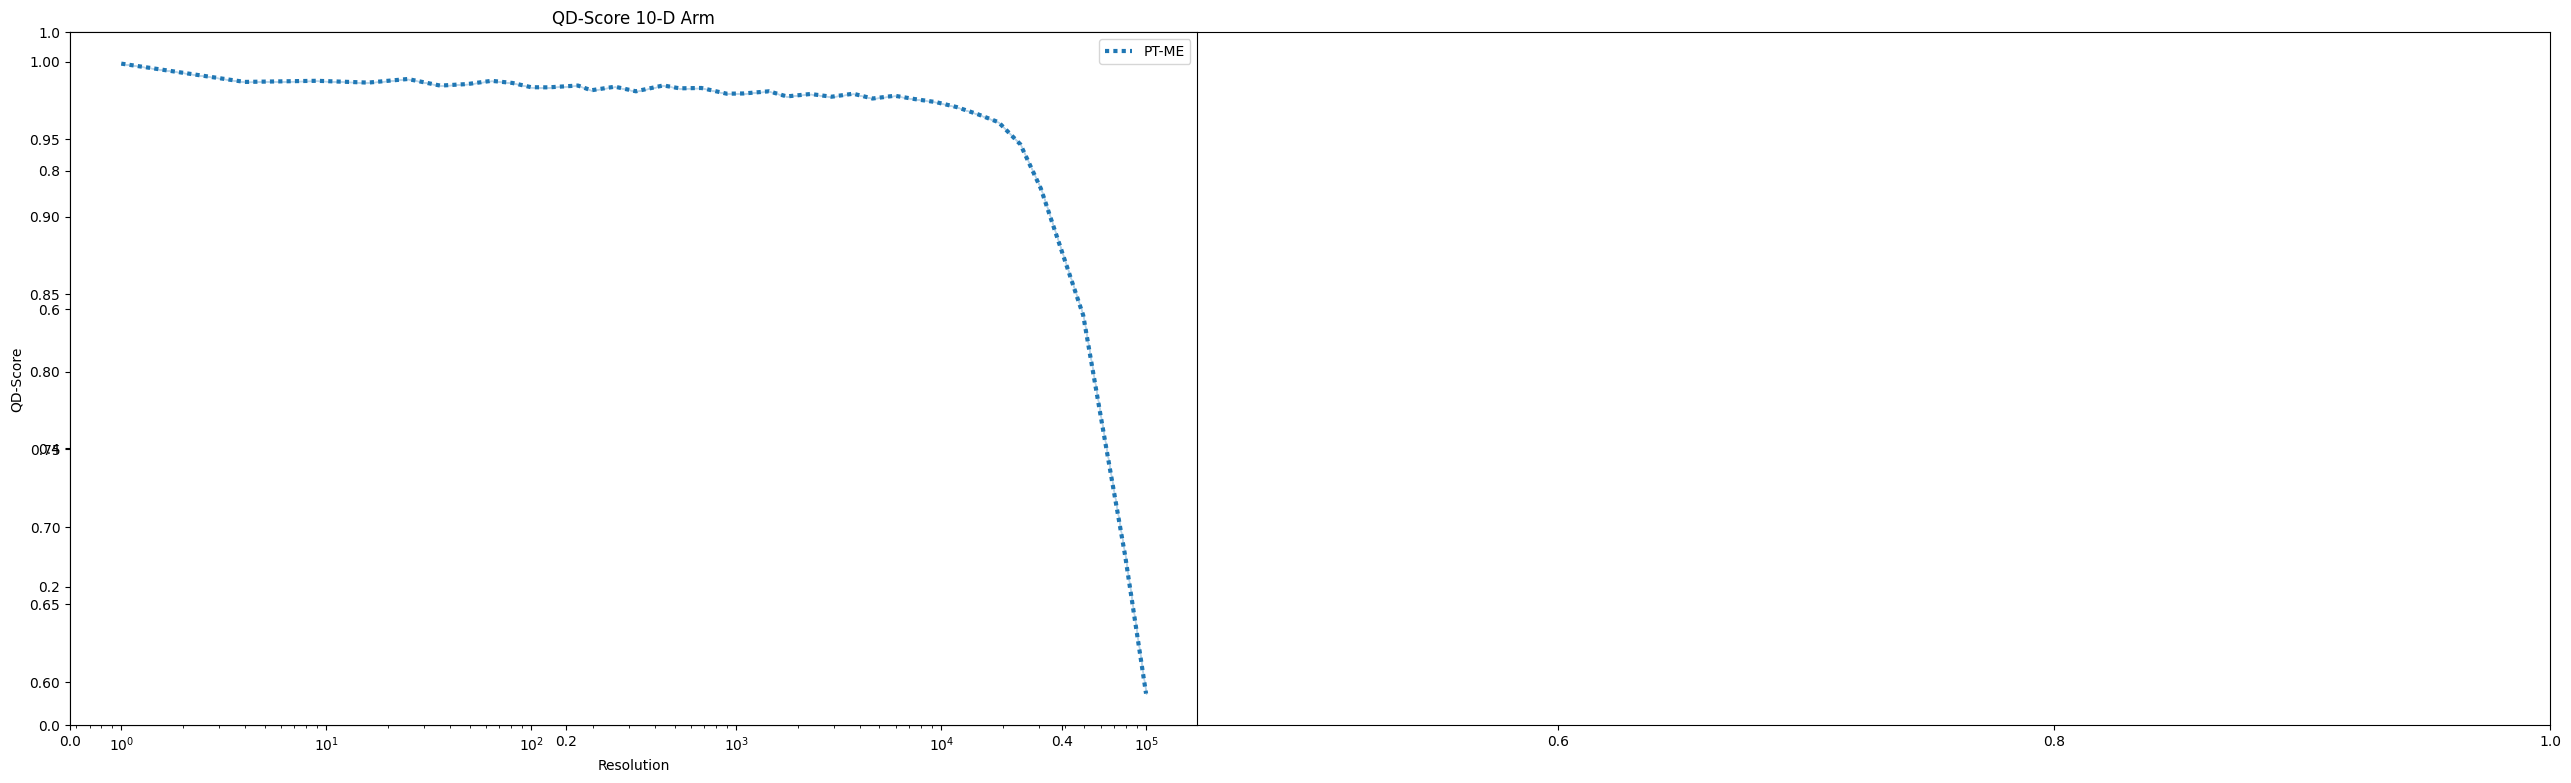

In [52]:
data, labels, X = [], [], []
line_styles = []

for j, (name, qd_score) in enumerate(qd_score_PT_ME.items()):
    data.append(qd_score)
    line_styles.append(linestyles[j%len(linestyles)])
    labels.append(name)
    X.append(1/np.array(resolutions)**2)

plt.subplots(figsize=(16*2,9))
plt.subplot2grid((1,2), (0,0))
plot_with_spread(data, labels, X, cm.tab10, line_styles=line_styles)
plt.legend(bbox_to_anchor=(1,1,0,0))
plt.xscale("log")
plt.xlabel("Resolution")
plt.ylabel(f"QD-Score")
plt.title(f"QD-Score {env_name}")

In [53]:
for i, name in enumerate(labels):
    X = np.mean(data)
    print(name, f"MR-QD-Score: median:{np.median(X):1.4f} [25%, 75%]=[{np.quantile(X, 0.25):1.4f}, {np.quantile(X, 0.75):1.4f}] [5%, 95%]=[{np.quantile(X, 0.05):1.4f}, {np.quantile(X, 0.95):1.4f}]")

PT-ME MR-QD-Score: median:0.9489 [25%, 75%]=[0.9489, 0.9489] [5%, 95%]=[0.9489, 0.9489]
